In [ ]:
%%bash
pip install mxnet keras keras-mxnet matplotlib opencv-python sklearn

# Preparation

In [1]:
import mxnet as mx
import numpy as np
import keras as k
from matplotlib.pyplot import imshow
import cv2

%matplotlib inline

Using MXNet backend


In [2]:
SHAPE=(224, 224, 3)

import helpers.labelinputgenerator
trainData = helpers.labelinputgenerator.LabelInputGenerator("train", SHAPE, 3)
testData = helpers.labelinputgenerator.LabelInputGenerator("train", SHAPE, 3, shuffle=False)

print("Number of batches in the training data: ", len(trainData))
print("Number of batches in the Validation data: ", len(trainData))

Number of batches in the training data:  5
Number of batches in the Validation data:  5


# Test image

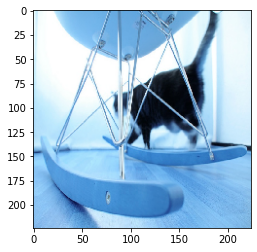

In [3]:
for x, y in trainData:
    imshow(x[0])
    break

# Setup NN

In [4]:
import models.dummy as m

NNmodel = m.create_model(input_shape=SHAPE, outputs=3)
NNmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 230, 230, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 23, 23, 32)        9632      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 23, 23, 32)        92        
_________________________________________________________________
activation_1 (Activation)    (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_layer (Dense)          (None, 5)                 84645     
__________

/Users/SEIDLM/workspaces/privat/ubiquitous-adventure/venv/lib/python3.7/site-packages/keras/backend/mxnet_backend.py:94: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.to_channels_first(x_input)`to transform `channels_last` data to `channels_first` format and also please change the `image_data_format` in `keras.json` to `channels_first`.Note: `x_input` is a Numpy tensor or a list of Numpy tensorRefer to: https://github.com/awslabs/keras-apache-mxnet/tree/master/docs/mxnet_backend/performance_guide.md
  train_symbol = func(*args, **kwargs)
/Users/SEIDLM/workspaces/privat/ubiquitous-adventure/venv/lib/python3.7/site-packages/keras/backend/mxnet_backend.py:97: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose oper

In [5]:
NUM_EPOCHS = 1
opt = k.optimizers.Adam()
NNmodel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [6]:
history = NNmodel.fit_generator(
	trainData,
	validation_data=testData,
	epochs=NUM_EPOCHS)

Epoch 1/1
5/5 [==============================] - 2s 377ms/step - loss: 0.4500 - acc: 0.8000 - val_loss: 2.6094e-04 - val_acc: 1.0000


/Users/SEIDLM/workspaces/privat/ubiquitous-adventure/venv/lib/python3.7/site-packages/mxnet/module/bucketing_module.py:426: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.03125). Is this intended?
  force_init=force_init)


## Save model

In [ ]:
# serialize model to JSON
model_json = NNmodel.to_json()
with open("result/classification_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
NNmodel.save_weights("result/classification_model.h5")
print("Saved model to disk")

# Evaluate Result

In [ ]:
valData = helpers.labelinputgenerator.LabelInputGenerator("train", SHAPE, 3, shuffle=False)
evaluation = NNmodel.evaluate_generator(valData)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

print('Validation loss:', evaluation[0])
print('Validation accuracy:', evaluation[1])

# Manual Evaluation

In [ ]:
prediction = NNmodel.predict_generator(valData)
prediction_classes = np.argmax(prediction, axis=1)

In [ ]:
val_y = valData.all_labels()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["None", "Cat", "Dog", "Human"]
print(classification_report(val_y, prediction_classes, target_names=target_names))